# CO395 Coursework 1

**Group** 36  
**Authors**:  Jiajun Chen, Peizhen Wu, Zhen Hao, Kai Zhang  
**Date**:  10/02/2019

Note: This is OOP verison of Decision Tree classifier for CO395 coursework 1.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Build the Tree

In [2]:
class DecisionTree():
    def __init__(self,train_set,train_label, level = 1):
        self.x = train_set
        self.y = train_label
        self.n = self.x.shape[0]
        self.col = self.x.shape[1]
        self.leaf = self.is_leaf()
        self.level = level
        self.gain= 0
        self.buildTree()

    def buildTree(self):
        '''
        Main function for building the tree
        '''
        if self.is_leaf():
            self.classes = self.majority_vote()
            return
        else:
            self.find_split()
            l_idx = np.nonzero(self.x[:,self.attribute] <= self.value)[0]
            r_idx = np.nonzero(self.x[:,self.attribute] > self.value)[0]

            if len(l_idx) == 0 or len(r_idx) == 0:
                self.leaf = True
                self.classes = self.majority_vote()
                return
            else:
                self.left = DecisionTree(self.x[l_idx], self.y[l_idx],self.level +1)
                self.right = DecisionTree(self.x[r_idx], self.y[r_idx], self.level + 1)

    def find_split(self):
        '''
        Function for finding the best split point
        '''        
        for var_idx in range(self.col):
            x = self.x[:,var_idx]
            sort_idx = np.argsort(x)
            sort_y, sort_x = self.y[sort_idx], x[sort_idx]
            curr_label=sort_y[0]

            for i in range(1,self.n):
                #only calculate information gain when there is a label change
                if sort_y[i] != curr_label:
                    curr_label = sort_y[i]
                    s_left = sort_y[:i]
                    s_right = sort_y[i:]
                    curr_gain = self.infomation_gain(sort_y, s_left, s_right)
                    if curr_gain > self.gain:
                        self.gain = curr_gain
                        self.value = (sort_x[i] + sort_x[i-1]) /2
                        self.attribute = var_idx

    def entropy(self, label):
         # Count number of label and frequency
        unique, counts = np.unique(label, return_counts=True)
        dist = counts / sum(counts)
        H = -sum(dist * np.log2(dist))
        return H

    def infomation_gain(self, S_all, S_left, S_right):
        remainder = len(S_left)/(len(S_left)+len(S_right)) * self.entropy(S_left) + len(S_right)/(len(S_left)+len(S_right)) * self.entropy(S_right)
        gain = self.entropy(S_all) - remainder
        return gain

    def majority_vote(self):
        label, counts = np.unique(self.y, return_counts=True)
        return label[np.argmax(counts)]


    def get_depth(self):
        '''
        This function return the depth of the decision tree. The start value(root node) is 1.
        '''
        if self.leaf:
            return self.level
        else:
            l_depth=self.left.get_depth()
            r_depth =self.right.get_depth()
            max_depth = max(l_depth, r_depth)
            return max_depth

    def get_num_leafs(self):
        '''
        This function return number of leaf nodes in the tree.
        '''
        if self.leaf: return 1
        else:
            return self.left.get_num_leafs() + self.right.get_num_leafs()


    def predict(self, test_set):
        prediction = np.array([self.predict_row(xi) for xi in test_set])
        return prediction

    def predict_row(self, x_new):
        if self.leaf:
            return self.classes
        else:
            if x_new[self.attribute] <= self.value:
                return self.left.predict_row(x_new)
            else:
                return self.right.predict_row(x_new)

    def is_leaf(self):
        return len(np.unique(self.y)) == 1

    def accuracy(self, test_set):
        '''
        This function return the prediction accuracy for an input set
        '''
        actual = test_set[:,-1]
        prediction = self.predict(test_set[:,:7])
        return sum(actual == prediction)/ len(actual)

    def prune(self,valid_set):
        '''
        This function take a training set and validation set, build a trained tree and apply the reduce-error-pruning rule on the tree level by level
        until there is no more error reduced. Output is the pruned tree.
        '''
        if self.left.leaf and self.right.leaf:
            if len(valid_set) ==0:
                return
            else:
                bef_acc =self.accuracy(valid_set)
                aft_label = self.majority_vote()
                aft_acc = np.sum(valid_set[:,-1] == aft_label) / valid_set.shape[0]
                if aft_acc > bef_acc:
                    self.leaf = True
                    self.classes = aft_label
                    del self.left
                    del self.right
                    return
        else:
            # divide subset by recursion
            idx = valid_set[:,self.attribute] < self.value
            left_subset_valid=valid_set[idx,:]
            right_subset_valid = valid_set[np.logical_not(idx),:]

            # Three other possible cases with different copy rule
            if self.left.leaf ==False and self.right.leaf == True:
                self.left.prune(left_subset_valid)

            elif self.left.leaf ==True and self.right.leaf == False:
                self.right.prune(right_subset_valid)

            elif self.left.leaf ==False and self.right.leaf == False:
                self.left.prune(left_subset_valid)
                self.right.prune(right_subset_valid)



    def post_prune(self, valid_set):
        '''
        This function repeatedly call prune() function until there is no more improvement in validation accuracy.
        '''
        curr_score = self.accuracy(valid_set)
        while True:
            self.prune(valid_set)
            tmp_score = self.accuracy(valid_set)
            if tmp_score <= curr_score:
                break
            else:
                curr_score = tmp_score

    def confusion_matrix(self, valid_set):
        '''
        This function construct the confusion matrix given a input set.
        '''
        prediction = self.predict(valid_set[:,:7])
        actual = valid_set[:,-1]
        labels = np.unique(actual)
        cm = np.zeros((len(labels), len(labels)),dtype=np.int32)
        for a, p in zip(actual.astype(int), prediction.astype(int)):
            cm[a-1][p-1] += 1
        return cm


## Evaluation

In [3]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Plot the confusion matrix
    '''
    print(title)
    print(cm)
    #classes = np.unique(actual).astype(int)
    classes = [1,2,3,4]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '2'
    thresh = cm.max() / 2.

    for i, j in ((i,j) for i in range(cm.shape[0]) for j in range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


def cross_validation_split(dataset, n_folds=10):
    '''
    Split a index into k folds
    '''
    fold_size = dataset.shape[0] / n_folds
    idx = np.random.permutation(dataset.shape[0])
    fold_idx = np.split(idx, n_folds)
    return fold_idx



def cross_valid(dataset, fold_idx):
    '''
    Evaluate the tree performance using cross validation
    '''
    n_label = len(np.unique(dataset[:,-1]))
    cm = np.zeros((n_label,n_label))
    for valid_idx in fold_idx:
        valid_set = dataset[valid_idx,:]
        train_idx = np.delete(np.arange(dataset.shape[0]), valid_idx)
        train_set = dataset[train_idx,:]
        dtree = DecisionTree(train_set[:,:7],train_set[:,-1])
        cm += dtree.confusion_matrix(valid_set)
    cm /= len(fold_idx)
    return cm

def cross_valid_prune(dataset, fold_idx):
    '''
    Evaluate the pruned tree performance using cross validation
    '''
    n_label = len(np.unique(dataset[:,-1]))
    cm = np.zeros((n_label,n_label))
    for valid_idx in fold_idx:
        prune_index = fold_idx[(i)%10]
        prune_set = dataset[prune_index,:]
        valid_set = dataset[valid_idx,:]
        delete_index = np.concatenate([prune_index, valid_idx])
        train_idx = np.delete(np.arange(dataset.shape[0]), delete_index)
        train_set = dataset[train_idx,:]
        dtree = DecisionTree(train_set[:,:7],train_set[:,-1])
        dtree.post_prune(prune_set)
        cm += dtree.confusion_matrix(valid_set)
    cm /= len(fold_idx)
    return cm


def evaluation_metrics(cm):
    plot_confusion_matrix(cm)
    np.set_printoptions(precision=5)
    print("Recall: ",recalls(cm), "\n","Precision: ", precisions(cm), "\n",
        "F1 score: ", F1Measure(cm), "\n","Classification_rate: ", '%.5f' % classification_rate(cm))

def recalls(cm):
    size = len(cm)
    recalls = np.zeros(size)
    for i in range(size):
        total = cm[i,:]
        recalls[i] =  cm[i][i]/sum(total)
    return recalls

def precisions(cm):
    size = len(cm)
    precisions = np.zeros(size)
    for i in range(size):
        pred_total = cm[:,i]
        precisions[i] = cm[i][i]/sum(pred_total)
    return precisions

def F1Measure(cm):
    avg_recalls = recalls(cm)
    avg_precisions = precisions(cm)
    F1_score = []
    for recall, precision in zip(avg_recalls, avg_precisions):
        F1_score.append( 2*(precision*recall)/(precision+recall))
    return np.array(F1_score)

def classification_rate(cm):
    return sum(np.diag(cm))/sum(sum(cm))




In [4]:
def evaluate(dataset):
    '''
    Main function to call to run the processes automatically given a dataset
    '''
    n_folds = 10
    dtree = DecisionTree(dataset[:,:7],dataset[:,-1])
    fold_idx = cross_validation_split(dataset, n_folds)
    print('Cross validation on pre-pruned tree:\n')
    cm = cross_valid(dataset,fold_idx)
    evaluation_metrics(cm)
    print('\nCross validation on post-pruned tree:\n')  
    cm_prune = cross_valid_prune(dataset,fold_idx)
    evaluation_metrics(cm_prune)
    

## Tree Visualization

In [150]:
decisionNode=dict(boxstyle="square",fc="w", pad=0.5)
leafNode=dict(boxstyle="circle",fc="w")
arrow_args=dict(arrowstyle="<-",shrinkA = 20,shrinkB=20)


# Define the function in plotting node and leaf
def plotNode(nodeText,centerPt,parentPt,nodeType):
    # Define the property of Node and Leaf

    createPlot.ax1.annotate(nodeText,xy=parentPt,xycoords='axes fraction',xytext=centerPt,textcoords='axes fraction',
                           va='center',ha='center',size=12,bbox=nodeType,arrowprops=arrow_args)

# define the main functions, plotTree
def plotTree(inTree, parentPt):

    numLeafs = inTree.get_num_leafs()   #this determines the x width of this tree
    depth = inTree.get_depth()
    nodeStr='X' + str(inTree.attribute)  + ' < ' + str(inTree.value)  #the text label for this node should be this
    cntrPt = (plotTree.xOff +  8/plotTree.totalW, plotTree.yOff)      # location of the node
    plotNode(nodeStr, cntrPt, parentPt, decisionNode)       # plot the node
    plotTree.yOff = plotTree.yOff - 4/plotTree.totalD   # Move to next level to change yoff
    if not inTree.left.leaf:  #test to see if the nodes are leaf node
        plotTree(inTree.left,cntrPt)        # if not, recursion
    else:                                             #it's a leaf node print the leaf node
        leafStr = 'Leaf:' + str(inTree.left.classes)
        plotTree.xOff = plotTree.xOff + 8/plotTree.totalW
        plotNode(leafStr, (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
    if not inTree.right.leaf:  #test to see if the nodes are leaf node
        plotTree(inTree.right,cntrPt)        #recursion
    else:                                             #it's a leaf node print the leaf node

        leafStr = 'Leaf:' + str(inTree.right.classes)
        plotTree.xOff = plotTree.xOff + 8 /plotTree.totalW
        plotNode(leafStr, (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
    plotTree.yOff = plotTree.yOff + 4/plotTree.totalD

# create the plot of decision tree
def createPlot(inTree):
    fig=plt.figure(1,figsize=(7,7),facecolor='white')
    fig.clf()
    axprops=dict(xticks=[],yticks=[])
    createPlot.ax1=plt.subplot(frameon=False,**axprops)
    plotTree.totalW=float(inTree.get_num_leafs())
    plotTree.totalD=float(inTree.get_depth())
    plotTree.xOff=0
    plotTree.yOff=3.5
    # Initialize the root location
    init_loc = cntrPt = (plotTree.xOff + 8/plotTree.totalW , plotTree.yOff)
    plotTree(inTree, init_loc)
    plt.savefig('treeplot.png', bbox_inches="tight")


## Main

In [6]:
np.random.seed(42)
# Load the clean dataset
data_clean = np.loadtxt('wifi_db/clean_dataset.txt')
data_noisy = np.loadtxt('wifi_db/noisy_dataset.txt')

In [7]:
# Shuffle data
np.random.shuffle(data_clean)
np.random.shuffle(data_noisy)

Cross validation on pre-pruned tree:

Confusion matrix
[[49.5  0.   0.2  0.3]
 [ 0.  47.5  2.5  0. ]
 [ 0.6  1.6 47.4  0.4]
 [ 0.5  0.   0.2 49.3]]


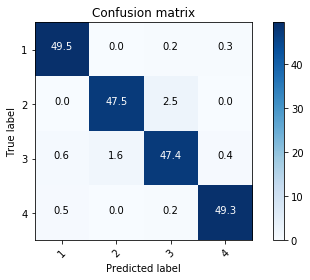

Recall:  [0.99  0.95  0.948 0.986] 
 Precision:  [0.97826 0.96741 0.94235 0.986  ] 
 F1 score:  [0.9841  0.95863 0.94516 0.986  ] 
 Classification_rate:  0.96850

Cross validation on post-pruned tree:

Confusion matrix
[[49.6  0.   0.2  0.2]
 [ 0.  47.7  2.3  0. ]
 [ 0.6  2.3 47.   0.1]
 [ 0.3  0.   0.2 49.5]]


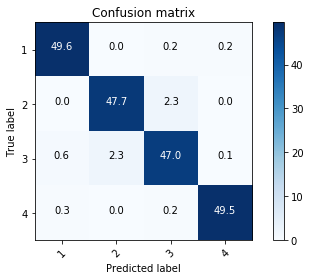

Recall:  [0.992 0.954 0.94  0.99 ] 
 Precision:  [0.98218 0.954   0.94567 0.99398] 
 F1 score:  [0.98706 0.954   0.94283 0.99198] 
 Classification_rate:  0.96900


In [53]:
evaluate(data_clean)

Cross validation on pre-pruned tree:

Confusion matrix
[[43.5  1.6  1.6  2.3]
 [ 3.1 42.1  3.   1.5]
 [ 2.7  3.2 43.2  2.4]
 [ 2.4  1.8  2.  43.6]]


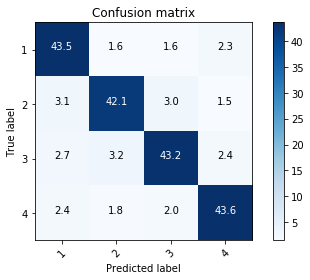

Recall [0.88776 0.84708 0.83883 0.8755 ] 
 Precision [0.84139 0.86448 0.86747 0.8755 ] 
 F1 score [0.86395 0.85569 0.85291 0.8755 ] 
 Classification_rate 0.862

Cross validation on post-pruned tree:

Confusion matrix
[[43.5  1.3  1.7  2.5]
 [ 2.6 42.8  2.7  1.6]
 [ 2.5  3.8 43.3  1.9]
 [ 3.6  1.7  2.3 42.2]]


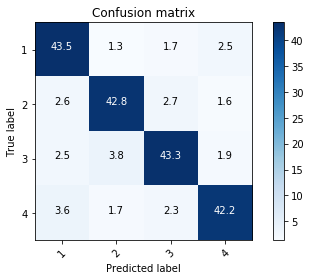

Recall [0.88776 0.86117 0.84078 0.84739] 
 Precision [0.83333 0.8629  0.866   0.87552] 
 F1 score [0.85968 0.86203 0.8532  0.86122] 
 Classification_rate 0.859


In [51]:
evaluate(data_noisy)

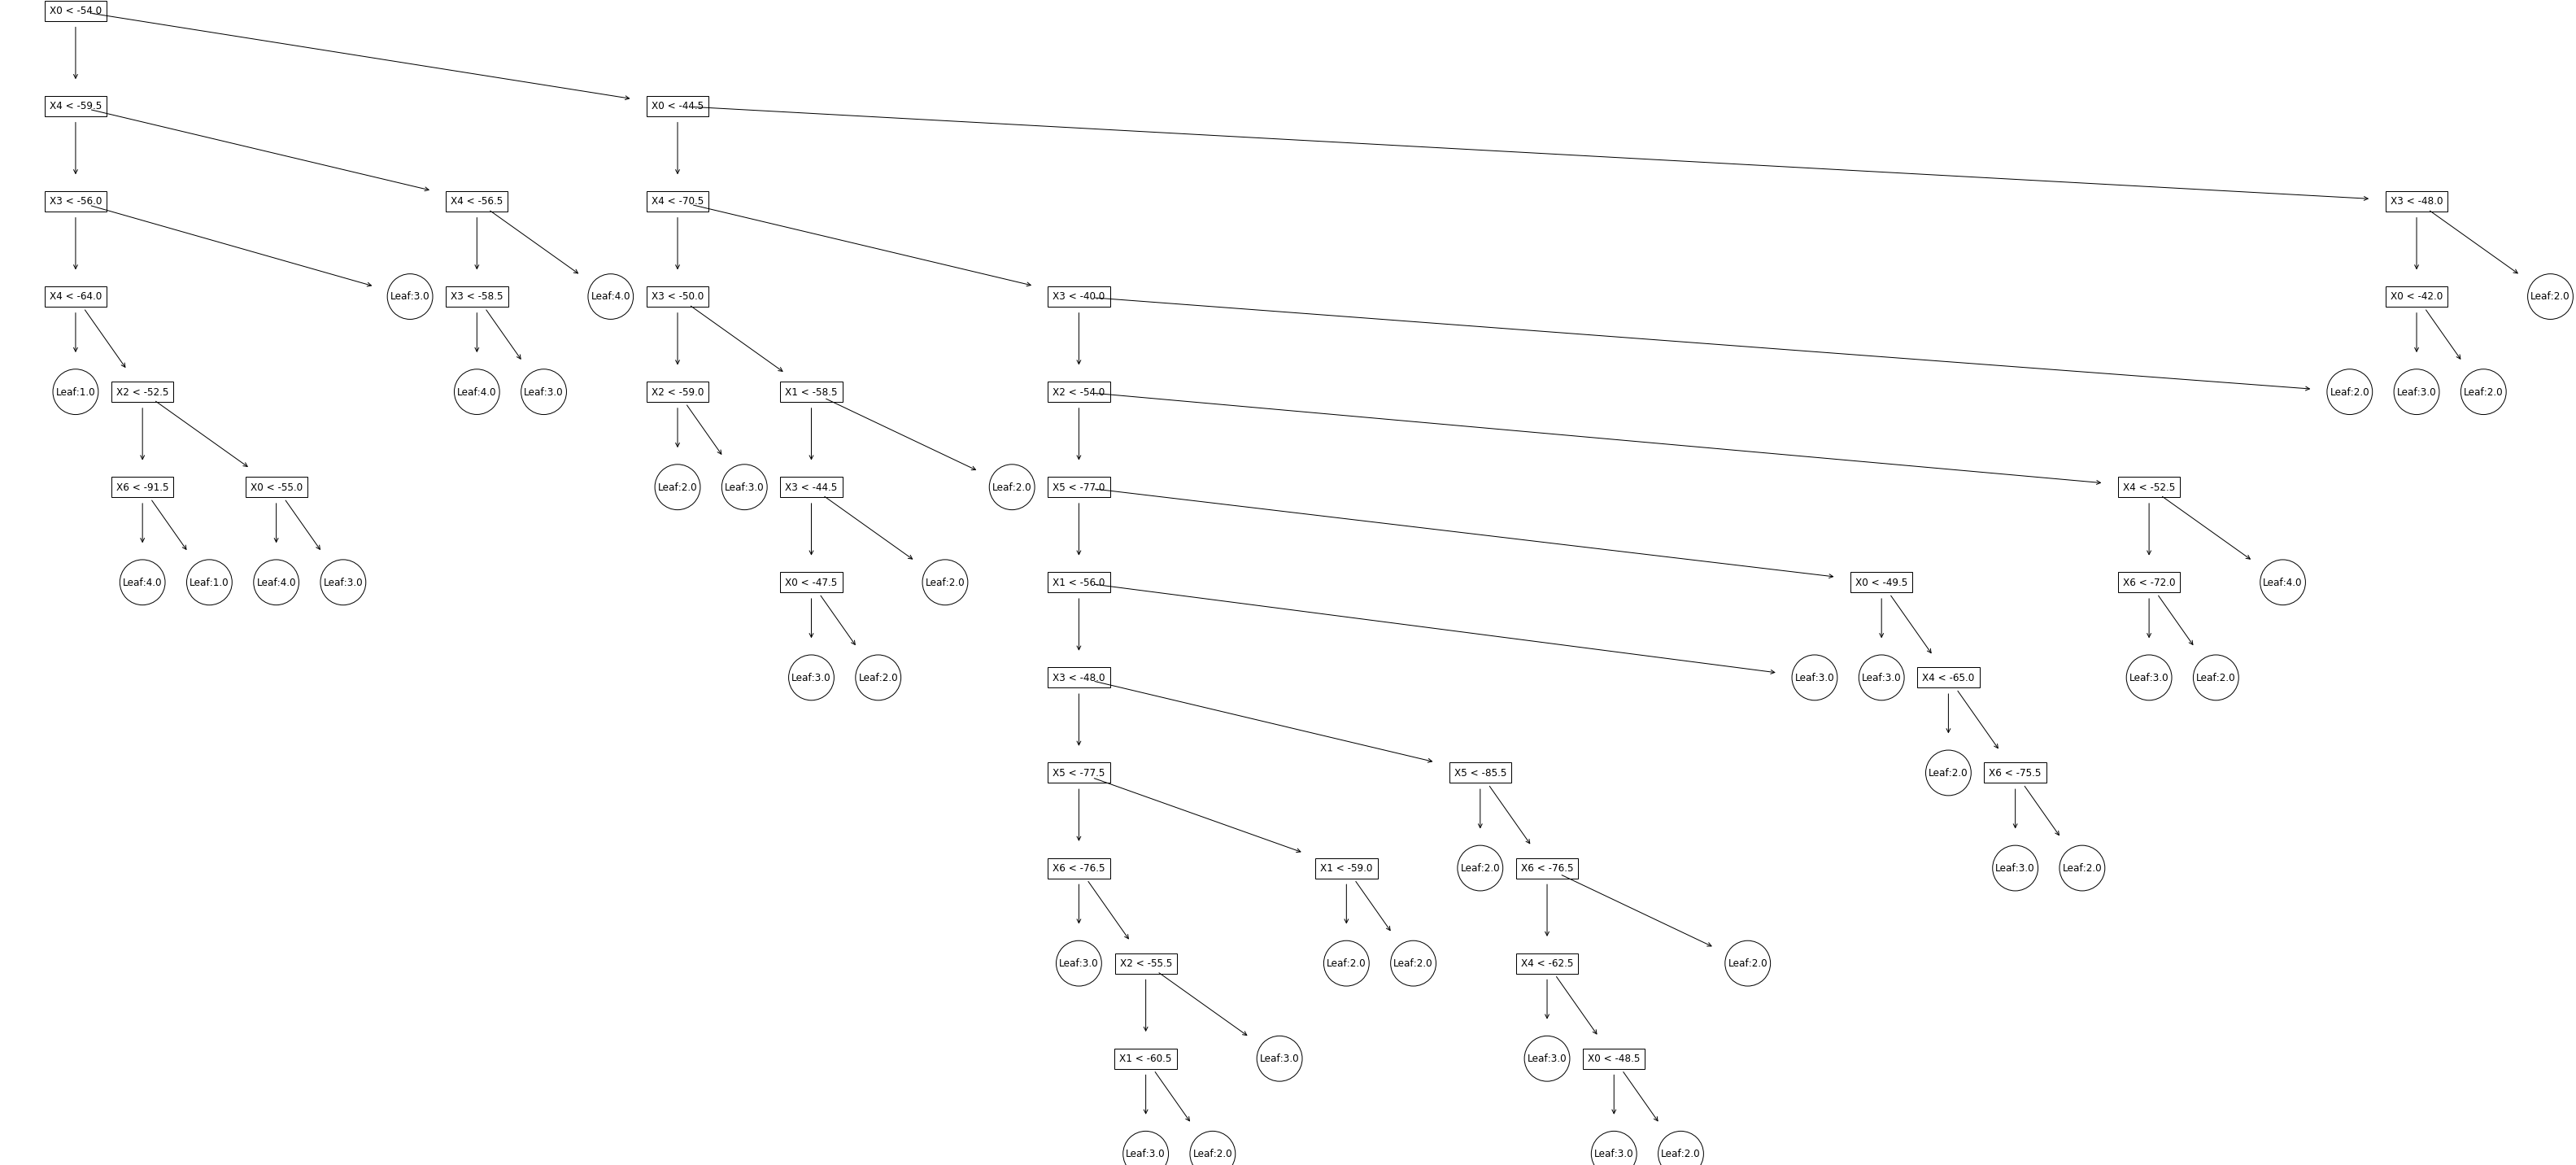

In [152]:
# Tree visualization
dtree = DecisionTree(data_clean[:,:7], data_clean[:,-1])
createPlot(dtree)